# Estimating Distributions

## Representation Bias - Single Series

First, we will test the "representation bias" of various probability distributions on a large sample of streamflow timeseries:

1. Define distributions to compare (continuous parametric/nonparametric, discrete nonparametric),
2. Fit continuous distributions to observed series (MLE, KDE),
4. Compute empirical CDF to observations,
5. Define a range of dictionary sizes to test numerical approximation,
6. Compute the quantization noise associated with each dictionary size,
7. Determine the "representation bias" between distribution estimates and the baseline,
8. Note how often the various methods fail to converge.

It is challenging to look at single distributions and determine what constitutes "sufficiency" as far as capturing the shape of the distribution.  For long periods of record covering many years, it seems more reasonable to link distribution shape to dominant processes, and for short periods it seems more appropriate to assign shape to interannual variability.  Where does one give way to the other?  It is tempting to look at a short period of record and "fill in the blanks", or imagine how smooth the shape becomes over time.  

It is informative to look at a large number of samples to get a sense of the variability in distribution shapes, and looking at samples of pairs adds a dimension to the question of sufficiency in representation.  For long (concurrent) records, what drives the observed range to align, or the mode, or the number of modes?  What drives the tail behaviour?  For shorter (concurrent) records, could greater similarity in distribution shape suggest a kind of process correlation at some spatial, temporal or spatial?  

## Pairwise Comparisons - Reliability of Representation for Support Coverage

Ultimately the goal is to compare distributions, but we just saw that parametric distributions don't always converge with MLE.  

1. For each distribution representation type (parametric, KDE, discrete):
    * generate a large random sample of distribution pairs
    * determine frequency of incomplete support coverage
    * adjust Q where necessary for support coverage
    * compute KL divergence between P and Q
    * compare representation bias to KL divergence
    * determine if bias suppresses or inflates KL divergence

In [1]:
import os
from time import time
from scipy.stats import entropy
import multiprocessing as mp
import data_processing_functions as dpf
import numpy as np
import pandas as pd

# visualize the catchment centroid locations
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.palettes import Colorblind, Sunset10

from scipy.stats import lognorm, expon, kappa4, genpareto, gaussian_kde
from scipy.stats import entropy, wasserstein_distance
from scipy.special import kl_div, gammaln
from scipy.optimize import minimize
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d

from lmoments3 import distr as lmom_dist

from KDEpy import FFTKDE

import jax
import jax.numpy as jnp
from jax import vmap
from jax.scipy.stats import gaussian_kde as jkde
from jax import config as jax_config
jax_config.update("jax_enable_x64", False)

from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

output_notebook()

BASE_DIR = os.getcwd()
print(BASE_DIR)

Loading BokehJS ...

/home/danbot2/code_5820/24/distribution_estimation/docs/notebooks


In [2]:
# import attributes 
rev_date = '20250227'
attributes_filename = f'BCUB_watershed_attributes_updated_{rev_date}.csv'
attributes_fpath = os.path.join(os.getcwd(), 'data', attributes_filename)
attr_df = pd.read_csv(attributes_fpath)
attr_df.columns = [e.lower() for e in attr_df.columns]
# df.columns
filtered_stns = sorted(list(set(attr_df['official_id'].values)))

## Part 1 - Compare Distribution Fits


### Define an approximate measurement error model

In [3]:
# Define the ranges and associated errors
error_points = jnp.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10, 1e2, 1e3, 1e4, 1e5])  # Magnitude points
error_values = jnp.array([1.0, 0.5, 0.2, 0.1, 0.05, 0.05, 0.1, 0.15, 0.20, 0.25])    # Associated errors (as proportions)

efig = figure(width=400, height=300, x_axis_type='log')
efig.line(error_points, error_values, line_color='red', line_width=2)
efig.xaxis.axis_label = r'$$\text{Flow } m^3/s$$'
efig.yaxis.axis_label = r'$$\text{Error } [\%]$$'
efig = dpf.format_fig_fonts(efig, font_size=12)
show(efig)

In [4]:
def compute_log_uniform_bins(x, bitrate, reserve_edges=False):
    n_bins = 2**bitrate #- 2
    if reserve_bin_edges == True:
        n_bins -= 2
    # set the bin edges to be evenly spaced between the
    # observed range of the proxy/donor series
    # np.digitize will assign 0 for out-of-range values at left
    # and n_bins + 1 for out-of-range values at right
    log_bin_edges = np.linspace(
        np.log10(np.min(x)),
        np.log10(np.max(x)),
        n_bins + 1,
    ).flatten()
    # convert back to linear space
    bin_edges = [10**e for e in log_bin_edges]
    return bin_edges


In [5]:
def compute_idealized_frequencies(data, bin_edges, bitrate):
    xq = np.digitize(data, bin_edges)
    # print(df[[stn, f'{stn}_quantized_{bitrate}bits']].head(4))
    # count the occurrences of each quantized value
    # the "simulated" series is the proxy/donor series
    # and the "observed" series is the target location
    unique, counts = np.unique(xq, return_counts=True)
    obs_count_dict = {k:v for k, v in zip(unique, counts)}
    # count_df = pd.DataFrame(index=range(0, 2**bitrate+2))
    count_df = pd.DataFrame(index=range(1, len(bin_edges)))
    count_df['counts'] = 0
    count_df['counts'] += count_df.index.map(obs_count_dict).fillna(0).astype(int)
    adjusted_p = count_df / len(data)
    return adjusted_p.values.flatten()

In [6]:
def interpolate_ecdf(intervals, x, ecdf_values):
    """
    Compute exact or linearly interpolated ECDF values for intervals using vectorized operations.

    Parameters:
    - intervals: numpy array of interval values.
    - observations: numpy array of sorted observations (x-values of the ECDF).
    - ecdf_values: numpy array of cumulative probabilities (y-values of the ECDF).

    Returns:
    - numpy array of interpolated ECDF values.
    """
    # Ensure inputs are numpy arrays
    intervals = jnp.asarray(intervals)
    observations = jnp.asarray(x)

    # Find insertion indices for intervals in the sorted observations
    indices = jnp.searchsorted(x, intervals, side='left')

    # Initialize result with boundary values
    result = np.zeros_like(intervals, dtype=jnp.float64)
    result[indices == 0] = 0.0  # Below the smallest observation
    result[indices == len(x)] = 1.0  # Above the largest observation

    # Interpolate for intervals within the range of observations
    within_range = (indices > 0) & (indices < len(x))
    idx = indices[within_range]

    # Get the left and right points for interpolation
    x_left = x[idx - 1]
    x_right = x[idx]
    y_left = ecdf_values[idx - 1]
    y_right = ecdf_values[idx]

    # Linear interpolation
    weights = (intervals[within_range] - x_left) / (x_right - x_left)
    result[within_range] = y_left + weights * (y_right - y_left)

    return jnp.diff(result)

In [7]:
def kde_adaptive_jax(x_eval, data, adaptive_bandwidths):
    """
    JAX-based adaptive Kernel Density Estimation (KDE) with vectorized computation.
    
    Parameters:
    - x_eval: Points at which to evaluate the density (array of shape (n_eval,)).
    - data: Data points (array of shape (n_data,)).
    - adaptive_bandwidths: Bandwidths for each data point (array of shape (n_data,)).
    
    Returns:
    - Density estimates at x_eval (array of shape (n_eval,)).
    """
    x_eval = jnp.array(x_eval)
    # Compute pairwise differences between evaluation points and data
    diffs = (x_eval[:, None] - data[None, :])  # Shape: (n_eval, n_data)
    
    # Scale by adaptive bandwidths
    scaled_diffs = diffs / adaptive_bandwidths  # Broadcasting over n_data
    
    # Compute Gaussian kernel values
    kernel_values = jnp.exp(-0.5 * scaled_diffs**2) / (jnp.sqrt(2 * jnp.pi) * adaptive_bandwidths)

    # Average contributions from all data points
    density = jnp.mean(kernel_values, axis=1)  # Shape: (n_eval,)
    
    return density

def fit_gaussian_mixture(data, n_gaussian_procs=2):    
    gmm = GaussianMixture(n_components=n_gaussian_procs, random_state=0)
    gmm.fit(data.reshape(-1, 1))
    # Evaluate the pilot density at each data point
    pilot_density = np.exp(gmm.score_samples(data.reshape(-1, 1)))
    
    # Step 2: Compute adaptive bandwidths
    geometric_mean = np.exp(np.mean(np.log(pilot_density)))  # Geometric mean of pilot density
    beta = 0.5  # Adaptation strength
    lambda_0 = 1.06 * np.std(data) * len(data)**(-1/5)  # Silverman's rule for initial bandwidth
    adaptive_bandwidths = lambda_0 * (pilot_density / geometric_mean)**(-beta)
    return adaptive_bandwidths

In [8]:
# Kernel function: Gaussian
def gaussian_kernel(u):
    """
    Gaussian kernel function.
    """
    return jnp.exp(-0.5 * u**2) / jnp.sqrt(2 * jnp.pi)

# Adaptive KDE function
def adaptive_kde(x_eval, data, error_func, scaling_factor=1.0):
    """
    Adaptive Kernel Density Estimation using JAX.
    
    Parameters:
    - x_eval: Points at which to evaluate the density (array of shape (n_eval,)).
    - data: Data points (array of shape (n_data,)).
    - error_func: Function describing measurement error as a function of x.
    - scaling_factor: Scaling factor for bandwidth.
    
    Returns:
    - Density estimates at x_eval (array of shape (n_eval,)).
    """
    # Compute adaptive bandwidths based on measurement error
    bandwidths = scaling_factor * vmap(error_func)(data)

    # Compute pairwise differences scaled by bandwidths
    diffs = (x_eval[:, None] - data[None, :]) / bandwidths[None, :]

    # Apply Gaussian kernel and scale by bandwidths
    kernel_values = gaussian_kernel(diffs) / bandwidths[None, :]

    # Average kernel contributions
    density = jnp.mean(kernel_values, axis=1)
    return density

In [9]:
def fit_continuous_distributions(data, n_gaussian_procs=2):
    """Fit continuous distributions to an input array representing
    time series observations."""
    # fit and plot a lognormal distribution
    t0 = time()
    lnorm_shape, lnorm_loc, lnorm_scale = lognorm.fit(data)
    t1 = time()
    # lognorm = dict(lmom_dist.gno.lmom_fit(np.log10(data)))  # Fixing location to 0
    # ex_loc, ex_scale = expon.fit(data, floc=0)
    # ex_loc, ex_scale = lmom_dist.exp.lmom_fit(data)
    # exp = dict(lmom_dist.exp.lmom_fit(np.log10(data)))
    exp = dict(lmom_dist.exp.lmom_fit(data))
    t2 = time()
    # exp = dict(lmom_dist.exp.lmom_fit(data))
    gpa = dict(lmom_dist.gpa.lmom_fit(data))
    t3 = time()
    try:
        kp4 = dict(lmom_dist.kap.lmom_fit(data))
    except Exception as ex:
        kp4 = None
    
    t5 = time()
    log_data = jnp.log10(data)
    kde_jax = jkde(log_data, bw_method='silverman')
   
    gmm = fit_gaussian_mixture(log_data, n_gaussian_procs=n_gaussian_procs)

    return {
        'LogNorm': {'shape': lnorm_shape, 'loc': lnorm_loc, 'scale': lnorm_scale},
        'Expon': exp,
        'GPA': gpa,
        'Kappa4': kp4,
        'KDE': kde_jax,
        'GMM': gmm,
    }

In [10]:
@jax.jit
def vectorized_kde_integration(kde_fit_object, edges):\
    return jax.vmap(lambda le: kde_fit_object.integrate_box_1d(-jnp.inf, le))(jnp.array(edges))

In [11]:
def compute_fft_kde_fit(data, grid):    
    # input_data = jnp.log10(data)
    fft_weights = jnp.asarray(vmap(interpolate_error_model)(data)).copy()
    fft_weights /= jnp.sum(fft_weights)
    log_data = np.log10(data)
    fft_fit = FFTKDE(bw='silverman').fit(log_data, weights=np.array(fft_weights))
    x, y = fft_fit.evaluate()
    fft_density = fft_fit.evaluate(grid)
    # f = interp1d(x, y, kind="slinear", assume_sorted=True)
    # fft_density = f(grid)
    fft_kde_cdf = jnp.cumsum(fft_density) * (grid[1] - grid[0])
    # Normalize CDF to ensure it sums to 1
    fft_kde_cdf /= fft_kde_cdf[-1]
    return fft_kde_cdf

In [12]:
def numerical_approximation_of_continuous_pmfs(data, stn, continuous_fits, linear_edges, log_edges):
    t0 = time()
    
    log_range = log_edges[-1] - log_edges[0]
    log_data = np.log10(data)
    
    # set the number of bin edges to 1% of the range
    num_points = int(np.ceil(log_range / np.log10(1.0/0.995))) + 1 # Include both endpoints

    # Explicitly calculate the bin width
    bin_width = log_range / (num_points - 1)

    # Use integer indexing to construct the grid
    # pdf_eval_grid = log_edges[0] + bin_width * np.arange(num_points)
    pdf_eval_grid = np.linspace(log_edges[0] - bin_width, log_edges[-1] + bin_width, num_points)

    assert (pdf_eval_grid.min() < log_data.min()).all(), 'min data is outside grid'
            
    assert (pdf_eval_grid.max() > log_data.max()).all(), 'max_data is outside grid'

    lin_grid = np.power(10, pdf_eval_grid)
    # diffs = np.diff(pdf_eval_grid)
    
    # foo1, foo2 = np.unique(diffs, return_counts=True)
    # assert np.allclose(np.ones_like(diffs) * diffs[0], diffs)

    # check the maximum bin width the fft eval grid numerical approximation represents
    # max_lin_equiv = jnp.power(10, pdf_eval_grid[-1]) - np.power(10, pdf_eval_grid[-2])
    # print(num_points, max_lin_equiv, max_lin_equiv / np.power(10, log_edges[-1]))

    # all parametric distributions were fit on un-transformed data, so evaluate on linear cdf grid
    logNorm = continuous_fits['LogNorm']
    ln_cdf_vals = lognorm.cdf(lin_grid, logNorm['shape'], loc=logNorm['loc'], scale=logNorm['scale'])
    
    exponential = continuous_fits['Expon']
    expon_cdf_vals = lmom_dist.exp.cdf(lin_grid, loc=exponential['loc'], 
                               scale=exponential['scale'])
    gen_pareto = continuous_fits['GPA']
    gpr_cdf_vals = lmom_dist.gpa.cdf(lin_grid, gen_pareto['c'], 
                                 loc=gen_pareto['loc'],
                                  scale=gen_pareto['scale'])
    
    kap = continuous_fits['Kappa4']
    if kap == None:
        kappa4_cdf_vals = jnp.array([np.nan for _ in lin_grid])
    else:
        # kappa4_cdf_vals = lmom_dist.kap.cdf(linear_edges, kap['k'], kap['h'], kap['loc'], kap['scale'])
        kappa4_cdf_vals = lmom_dist.kap.cdf(lin_grid, kap['k'], kap['h'], kap['loc'], kap['scale'])

    # all KDE and GMM were fit on log-transformed data, so evaluate on log pdf grid    
    kde_cdf_vals = vectorized_kde_integration(continuous_fits['KDE'], pdf_eval_grid)  

    fft_kde_cdf = compute_fft_kde_fit(data, pdf_eval_grid)

    gmm_adaptive_bandwidths = continuous_fits['GMM']
    gmm_density = kde_adaptive_jax(pdf_eval_grid, log_data, jnp.array(gmm_adaptive_bandwidths))
    # if bin edges are uneven, we need trapz to integrate
    # gmm_cdf_vals = np.array([np.trapz(gmm_density[:i], log_edges[:i]) for i in range(1, len(log_edges) + 1)])
    # gmm_cdf_vals = jnp.cumsum(gmm_density) * (log_edges[1] - log_edges[0])
    gmm_cdf_vals = jnp.cumsum(gmm_density) * (pdf_eval_grid[1] - pdf_eval_grid[0])
    gmm_cdf_vals /= gmm_cdf_vals[-1]
    
    p_sim = pd.DataFrame()
    p_sim['LN'] = jnp.diff(ln_cdf_vals)
    p_sim['EXP'] = jnp.diff(expon_cdf_vals)
    p_sim['GPR'] = jnp.diff(gpr_cdf_vals)
    p_sim['KP4'] = jnp.diff(kappa4_cdf_vals)
    p_sim['KDE'] = jnp.diff(kde_cdf_vals)
    p_sim['FFTKDE'] = jnp.diff(fft_kde_cdf)
    p_sim['GMM'] = jnp.diff(gmm_cdf_vals)
    
    # normalize the distributions
    p_sim /= p_sim.sum()
    linear_bin_midpoints = (jnp.array(pdf_eval_grid[:-1]) + jnp.array(pdf_eval_grid[1:])) / 2.0
    log_bin_midpoints = jnp.power(10, (jnp.array(pdf_eval_grid[:-1]) + jnp.array(pdf_eval_grid[1:])) / 2.0)

    p_sim['linear_bin_midpoints'] = linear_bin_midpoints
    p_sim['log_bin_midpoints'] = log_bin_midpoints
    return p_sim

In [13]:
def compute_kl_divergence(P, Q):
    """Compute the KL divergence DKL(P || Q)."""
    return jnp.round(jnp.sum(P * jnp.log(P / Q), where=(P != 0)), 3)

def compare_distributions(pmfs, epsilon=1e-12):
    cols = pmfs.columns
    result = {}
    p = pmfs['KDE'].values
    for c in pmfs.columns:
        if (c == 'KDE') | (c.endswith('_bin_midpoints')) | (c == 'incomplete_support'):
            continue
        q = pmfs[c].values
        result[f'{c}_KLD'] = compute_kl_divergence(p, q)
        
    return result

def compute_entropy(pmfs, b):
    result = {}
    for c in pmfs.columns:
        if (c == 'KDE') | (c.endswith('_bin_midpoints')):
            continue
        p = pmfs[c].values
        h = jnp.nansum(-1.0 * p * jnp.log2(p))
        result[f'{c}_entropy'] = jnp.round(h / b, 3)
    return result

In [14]:
def error_adjusted_fractional_bin_counts(
    observations, bin_edges, bitrate, error_factor=0.1
):
    """
    Computes error-adjusted fractional bin counts for a given set of values by considering an error factor.

    Parameters
    ----------
    observations : array-like
        An array or list of numerical values for which the fractional bin counts are to be computed.
    bin_edges : np.ndarray
        The edges of the bins used for quantizing the values.
    error_factor : float, optional
        The factor of uniformly distributed error to be considered for each value (default is 0.1).

    Returns
    -------
    np.ndarray
        An array of fractional bin counts adjusted for the specified error factor.
    """
    n_bins = len(bin_edges) - 1

    # Add pseudo-bins at the extremes
    min_bin_edge, max_bin_edge = bin_edges[0], bin_edges[-1]
    extended_bin_edges = np.concatenate(
        [[min_bin_edge - 1], bin_edges, [max_bin_edge + 1]]
    )
    n_extended_bins = len(extended_bin_edges) - 1

    lower_bounds = observations * (1 - error_factor)
    upper_bounds = observations * (1 + error_factor)

    # Compute observation ranges
    value_widths = upper_bounds - lower_bounds

    # Create a matrix of bin edges for extended bins
    bin_edges_lower = extended_bin_edges[:-1]
    bin_edges_upper = extended_bin_edges[1:]

    # Compute the amount each value +/- error overlaps the bins
    overlap_matrix = np.maximum(
        0,
        np.minimum(upper_bounds[:, None], bin_edges_upper)
        - np.maximum(lower_bounds[:, None], bin_edges_lower),
    )

    # Assert that the overlap matrix sums to the value bounds along rows
    assert np.allclose(
        np.sum(overlap_matrix, axis=1), value_widths, atol=1e-2
    ), f"Overlaps don't add up to value widths."

    # Fractional counts based on the overlap
    fractional_counts = overlap_matrix / value_widths[:, None]

    # Sum fractional counts for each bin
    bin_counts = np.sum(fractional_counts, axis=0)

    # Assert that fractional counts sum to 1 along rows
    assert np.allclose(
        np.sum(fractional_counts, axis=1), 1, atol=1e-2
    ), f"Fractional counts don't sum to 1."

    assert round(sum(bin_counts), 0) == len(
        observations
    ), f"Error in bin counts: {sum(bin_counts)} != {len(observations)}"

    return bin_counts


In [15]:
def error_adjusted_fractional_bin_counts_full(
    observations, bin_edges, bitrate, error_factor=0.1, adaptive_error=False,
):
    """
    Computes error-adjusted fractional bin counts, ensuring each observation contributes
    exactly 1 count, while separately tracking proportions outside the range.

    Parameters
    ----------
    observations : array-like
        An array or list of numerical values for which the fractional bin counts are to be computed.
    bin_edges : np.ndarray
        The edges of the bins used for quantizing the values.
    error_factor : float, optional
        The factor of uniformly distributed error to be considered for each value (default is 0.1).

    Returns
    -------
    bin_counts : np.ndarray
        Fractional bin counts, summing to the total number of observations.
    left_mass : float
        Total proportion of counts that fall below the smallest bin edge.
    right_mass : float
        Total proportion of counts that fall above the largest bin edge.
    """
    n_bins = len(bin_edges) - 1

    if adaptive_error == True:        
        # compute adaptive error factors from the error model function
        error_factor = vmap(interpolate_error_model)(observations)

    lower_bounds = observations * (1 - error_factor)
    upper_bounds = observations * (1 + error_factor)

    # Create a matrix of bin edges
    bin_edges_lower = bin_edges[:-1]
    bin_edges_upper = bin_edges[1:]

    # Compute the amount each value +/- error overlaps the bins
    overlap_matrix = np.maximum(
        0,
        np.minimum(upper_bounds[:, None], bin_edges_upper)
        - np.maximum(lower_bounds[:, None], bin_edges_lower),
    )

    # Compute out-of-range mass for each observation
    min_bin_edge, max_bin_edge = bin_edges[0], bin_edges[-1]
    left_mass_per_obs = np.maximum(0, min_bin_edge - lower_bounds)
    right_mass_per_obs = np.maximum(0, upper_bounds - max_bin_edge)

    # Total mass for each observation (overlaps + out-of-range)
    total_mass_per_obs = (
        np.sum(overlap_matrix, axis=1) + left_mass_per_obs + right_mass_per_obs
    )

    # Normalize to ensure each observation contributes exactly 1 count
    proportional_overlap_matrix = overlap_matrix / total_mass_per_obs[:, None]
    proportional_left_mass = left_mass_per_obs / total_mass_per_obs
    proportional_right_mass = right_mass_per_obs / total_mass_per_obs

    # Sum fractional contributions for each bin
    bin_counts = np.sum(proportional_overlap_matrix, axis=0)

    # Sum total left and right mass
    left_mass = np.sum(proportional_left_mass)
    right_mass = np.sum(proportional_right_mass)

    # Assert total counts match the number of observations
    assert np.allclose(
        np.sum(bin_counts) + left_mass + right_mass, len(observations), atol=1e-2
    ), f"Error in bin counts: {np.sum(bin_counts) + left_mass + right_mass} != {len(observations)}"

    return bin_counts, left_mass, right_mass

In [16]:
def apply_error_to_observations(data, bin_edges, bitrate=None, error=0.1):
    min_q, max_q = np.min(data) - 1e-9, np.max(data) + 1e-9
    assert min_q > 0
    # use equal width bins in log10 space
    # df[f'{bitrate}_bits_quantized'] = np.digitize(df[stn], bin_edges)
    fractional_counts = error_adjusted_fractional_bin_counts_full(
        data, np.array(bin_edges), bitrate, error_factor=error
    )
    
    count_df = pd.DataFrame(index=range(0, 2**bitrate))
    count_df[f'partial_count_{error}_error'] = fractional_counts
    adjusted_p = count_df / len(data)

    tot_counts = adjusted_p.sum(0).values[0]

    assert abs(tot_counts - 1.0) < 0.0001
    return adjusted_p.values.flatten()

# Interpolated error function
def interpolate_error_model(x):
    """
    Interpolate measurement error as a function of x using the provided error ranges.
    """
    return jnp.interp(x, error_points, error_values)

In [17]:
def compute_quantization_noise(x, linear_bin_edges, log_bin_edges, midpoint_method='log'):    
    bin_indices = np.digitize(x, linear_bin_edges)
    if midpoint_method == 'linear':
        bin_midpoints = 0.5 * (linear_bin_edges[:-1] + linear_bin_edges[1:])
    elif midpoint_method == 'log':
        bin_midpoints = 0.5 * (log_bin_edges[:-1] + log_bin_edges[1:])
        bin_midpoints = np.power(10, bin_midpoints)
    if min(x) < 0:
        raise Exception('Negative values encountered, is the data log-transformed?')

    quantization_noise = np.abs(x - bin_midpoints[bin_indices - 1])
    # compute the mean squared quantization error
    msqe = np.round(np.mean(quantization_noise**2), 3)
    # compute the variance of quantization noise
    vqn = np.round(np.var(quantization_noise), 3)
    # compute the SNR
    snr = np.round(10 * np.log10(np.var(x) / vqn), 3)
    # print(f'  MSQE: {msqe:.2f} VQN: {vqn:.2f} SNR: {snr:.3f}')
    return {'snr': snr, 'msqe': msqe, 'vqn': vqn}
    

In [18]:
def estimate_distributions(stn, epsilon=1e-9, binning_method='log', 
                           test_bitrates=None, test_error_rates=None, 
                           n_gaussian_procs=2):
    test_df = dpf.get_timeseries_data(stn)
    test_df.dropna(subset=[stn], inplace=True)
    test_df[stn].clip(lower=1e-4, inplace=True)

    min_observed = test_df[stn].min()

    data = test_df[stn].values
    x_min, x_max = np.min(data) - epsilon, np.max(data) + epsilon

    unique, counts = np.unique(data, return_counts=True)
    max_bitrate = np.floor(np.log2(len(unique)))
    # print(f'Observations can support max {max_bitrate} bits before oversampling.')
    # print(f'{stn}: {x_min:.3f}-{x_max:.1f}')
    

    # now iterate through a wide range of dictionary sizes to test 
    # the robustness of the parametric fit to the numerical approximation
    result = {}
    meta = {}
    meta['official_id'] = stn
    
    # get the number of unique values (to track outlier timeseries with no variance)
    n_unique_obs = len(unique)
    pct_unique = n_unique_obs / len(data)
    meta['n_unique_obs'] = n_unique_obs
    meta['pct_unique_obs'] = round(pct_unique, 3)
    meta['x_min'], meta['x_max'] = x_min, x_max
    meta['max_bitrate'] = max_bitrate
    meta['n_gaussian_procs'] = n_gaussian_procs
    
    continuous_fits = fit_continuous_distributions(data, n_gaussian_procs)
    for d in ['LogNorm', 'Expon', 'Kappa4']:
        # Check if the key exists and is not None
        if d in continuous_fits and continuous_fits[d] is not None:
            for kk, vv in continuous_fits[d].items():
                meta[f'{d}_{kk}'] = vv

    # stop before oversampling occurs.
    eval_bitrates = [br for br in test_bitrates if br <= max_bitrate]
    left_edge, right_edge = np.log10(x_min), np.log10(x_max)
    for b in eval_bitrates:
        # reserve a bin at each end as this will be done when comparing distributions
        # such that the comparisons are the same.
        n_bins = int(2**b)
        if min_observed > 1e-4:  
            default_min = np.log10(1e-4 - epsilon)
            logspace_edges_log = np.array([default_min] + list(np.linspace(left_edge, right_edge, n_bins-1)) + [right_edge + 1])
        else: 
            logspace_edges_log = np.array(list(np.linspace(left_edge, right_edge, n_bins)) + [right_edge + 1])

        logspace_edges_linear = np.power(10, logspace_edges_log)        
        # compute the quantization noise
        # note that using the log-based bin center reduces noise because in-bin sample is skewed
        # noise_dict = compute_quantization_noise(data, linear_bin_edges, log_bin_edges)
        # print(logspace_edges_linear)
        # print(logspace_edges_log)
        # print(asdf)
        noise_dict = compute_quantization_noise(data, logspace_edges_linear, logspace_edges_log)

        # compute numerical approximation of PMF for the current binning
        pmf_estimates = numerical_approximation_of_continuous_pmfs(data, stn, continuous_fits, 
                                                                   logspace_edges_linear, logspace_edges_log)

        partial_counts = pd.DataFrame()
        for er in test_error_rates:
            bin_counts, l_mass, r_mass = error_adjusted_fractional_bin_counts_full(data, logspace_edges_linear, 
                                                                                   bitrate=b, error_factor=er)
            partial_counts[f'partial_{er}'] = bin_counts / len(data)
            meta[f'partial_{er}_unsupported_left'] = l_mass
            meta[f'partial_{er}_unsupported_right'] = r_mass

        bin_counts, l_mass, r_mass = error_adjusted_fractional_bin_counts_full(data, logspace_edges_linear, 
                                                                               bitrate=b, error_factor=er, adaptive_error=True)
        
        # need to verify what the l_mass and r_mass represent, i.e. (check if it sums to 1)
        discrete_pmf_estimates = compute_idealized_frequencies(data, logspace_edges_linear, b)
        partial_counts['discrete'] = discrete_pmf_estimates
        # track MLE fits that yield q_i = 0
        support_dict = {}
        for c in pmf_estimates.columns:
            complete_support = True
            q = pmf_estimates[c].values
            if jnp.any(q == 0):
                complete_support = False
                pmf_estimates[c] *= len(data)
                # add 1 pseudo-count if any qi == 0
                pmf_estimates[c] += 1
                pmf_estimates[c] /= pmf_estimates[c].sum()
                
            support_dict[f'{c}_complete_support'] = complete_support 

        # compute the discrete PMF entropies
        entropy_normalized = compute_entropy(pmf_estimates, b)
        
        # compute the KL divergences between estimated PMFs
        kl_divergences = compare_distributions(pmf_estimates)
        result[b] = {
            'data': pmf_estimates, 
            'linear_edges': logspace_edges_linear, 
            'n_observations': len(data), 
            'discrete': partial_counts, 
        }
        result[b].update(support_dict)
        result[b].update(noise_dict)
        result[b].update(kl_divergences)
        result[b].update(entropy_normalized)

    output_df = pd.DataFrame(result).T
    output_df['bitrate'] = eval_bitrates
    keep_cols = [c for c in output_df.columns if c not in ['data', 'linear_edges', 'log_edges']]
    output_df = output_df[keep_cols] 
    for k, v in meta.items():
        output_df[k] = v
    return result, output_df, meta
    

In [19]:
from bokeh.palettes import Category20c, Bright, Accent8

binning_method = 'log'
test_bitrates = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
test_error_rates = [0.02, 0.05, 0.1, 0.2]

colors = Category20c[10]

# colors = Accent8
# pick a station to review
test_stn = filtered_stns[2]
# check outliers
test_stn = '12091050'
test_stn = '05AB022'
# test_stn = '08NL037'
# test_stn = '08LE087'
# test_stn = '08LF080'
# test_stn = '08LF081'
# test_stn = '09AA007'
# test_stn = '12078650'
# test_stn = '08NL040'
# test_stn = '05010500'
# test_stn = '07FA001'
# test_stn = '10ED002'
# test_stn = '08LE091'
test_stn = '05017500'
# test_stn = '12461500'
# test_stn = '12392450'
# test_stn = '12433558'
# test_stn = '15085300'
# test_stn = '12414350'
# test_stn = '15085400'
# test_stn = '15107910'
# test_stn = '15129600'
# test_stn = '14250000'

result, output_df, meta = estimate_distributions(test_stn, test_bitrates=test_bitrates, test_error_rates=test_error_rates)


In [20]:
def output_fit_plot(test_bitrates, meta, result):
    figs = []
    stn = meta['official_id']
    for b in [br for br in test_bitrates if br <= meta['max_bitrate']]:
        # if b >= 10:
        #     continue
        n = 0
        data = result[b]['data']
        pmfs = result[b]['discrete']
        freqs = pmfs['discrete']
        
        bin_edges = result[b]['linear_edges']
        print(f'Creating {stn} fit plot.')
    
        n_obs = result[b]['n_observations']
        n_years_equiv = n_obs / 365
        fig = figure(title=f'{b} bits (N={n_obs} obs ~{n_years_equiv:.0f} years)', 
                     width=700, height=400, x_axis_type='log')
        
        # assert abs(np.sum(freqs) - 1) < 0.0001
        fig.quad(left=bin_edges[:-1], right=bin_edges[1:], top=freqs, 
                      bottom=[0 for _ in freqs], legend_label=f'discrete', color=colors[n], 
                      line_color=None, fill_alpha=0.5)
        
        for et in test_error_rates:
            n += 1
            part_freqs = pmfs[f'partial_{et}']
            if et == 0.1:
                colour = 'grey'
            else:
                colour = colors[n]
            fig.quad(left=bin_edges[:-1], right=bin_edges[1:], top=part_freqs, 
                          bottom=[0 for _ in freqs], legend_label=f'{100*et:.0f}% err.', color=colour, 
                          line_color=None, fill_alpha=0.5)
    
        n = 0
        for l in data.columns:
            
            if l.startswith('partial') | l.endswith('_bin_midpoints') | (l == 'discrete'):
                continue
            elif l.startswith('adaptive'):
                continue
            else:
                label = l.split('_')[-1]
    
            if n == 3:
                n += 1
            
            clr = colors[n]
            
            if l == 'KDE':
                line_dash='dotted'
                clr = 'black'
            elif l == 'GMM':
                line_dash='dashed'
                clr = 'magenta'
            else:
                line_dash='solid'
                
            fig.line(x=data['log_bin_midpoints'].values, y=data[l].values, color=clr, 
                     legend_label=label, line_width=2, line_dash=line_dash)
            n += 1
        fig.yaxis.axis_label = r"$$\text{Pr}(x)$$"
        fig.xaxis.axis_label = r"$$\text{Flow} [m^3/s]$$"
        fig.legend.click_policy = 'hide'
        fig.legend.background_fill_alpha = 0.6
        fig = dpf.format_fig_fonts(fig, font_size=12)
        figs.append(fig)
    return figs



In [21]:
figs = output_fit_plot(test_bitrates, meta, result)
layout = gridplot(figs, ncols=2, width=550, height=425)
show(layout)

Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.
Creating 05017500 fit plot.


The plots for the example stations above are illustrations of challenges in determining the "best" representation of the data.  It also leads to an important consideration: what do differences mean, and what do their measures explain?

For example, looking at the example of '08LE091', water level and streamflow are continuous variables--rivers do not "jump" over certain levels.  The set of plots is chosen to cover a wide range of dictionary sizes, both the smallest and largest dictionary sizes are deliberately inappropriate choices for representing the observations.  The first plot (1 bit = 2 state dictionary) is far too coarse, throwing away much of the variability in the observed series.  The last plot (12 bits=4096 states) is highly oversampled.  Somewhere between the two is a representative quantization that balances bias and variance.  The question is how much detail represents genuine behaviour of the system.  

The more variance we throw away with coarse quantization, the more bias we introduce and the more we diminish the resulting discriminant.  

A few additional points that stand out about the distribution fits:

**Parametric**:
* the parametric forms tested are restricted to describing one mode, and maybe also some kind of limited tail behaviour
* It is difficult to say what the LogNorm, Exponential, or Kappa represent about the distribution.  

**Discrete**: 
* too small a dictionary size throws away too much information,
* increasing dictionary oversamples certain ranges first, and this is a vestige of the binning method capturing varying numbers of observations in each bin.

**KDE**: 
* seems robust to the quantization.  this is a property of the smoothing effect of the kernel, continuity / smoothness would probably disappear given a lower bandwidth.

Evaluate how robust the distributions are to the numerical approximation:
For each distribution, determine whether:
* noise variance is zero (
* an SNR value exists (i.e. noise is nonzero / noise variance is zero)
* the distribution fit yields any $\text{Pr}(x_i) = 0$ which would preclude a KL divergence

### Example Anomalies

**05017500**: 68 year record, strong bimodal distribution, KP4 does not like it
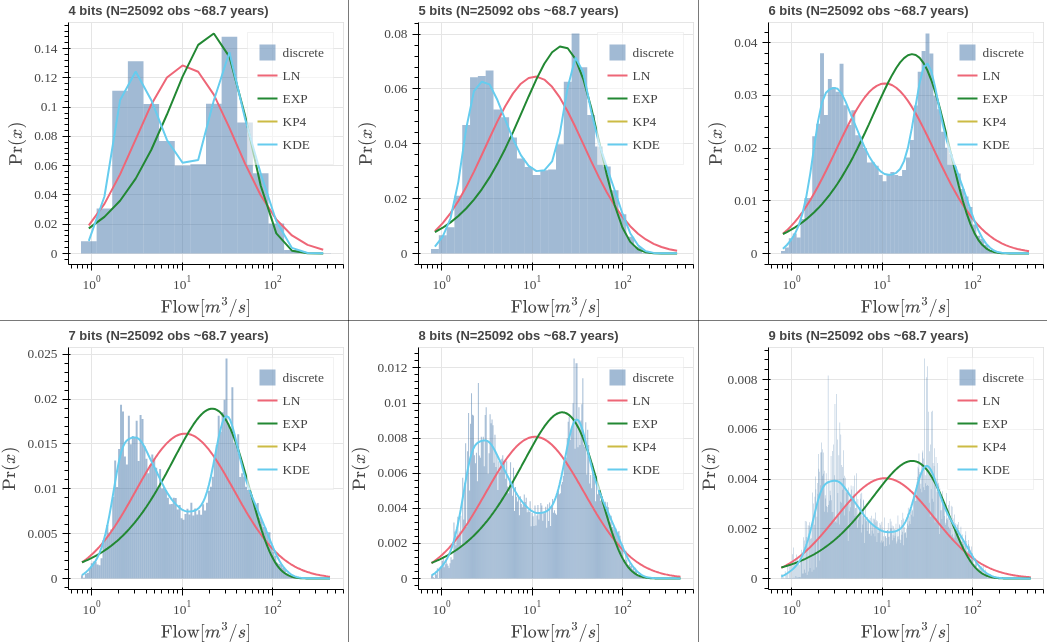

| **Aspect**                | **Kernel Density Estimation (KDE)**                                           | **Gaussian Mixture Model (GMM)**                                             |
|---------------------------|-------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| **Core Idea**             | Puts a kernel (e.g., Gaussian) at **each data point** and sums them.    | Assumes the data are generated by a mixture of a finite number of Gaussian distributions. |
| **Assumptions**           | Nonparametric: No assumptions about the underlying data distribution.         | Parametric: Assumes the data follow a mixture of Gaussian distributions.     |
| **Flexibility**           | Fully flexible: Adapts to any data shape, including multimodal distributions. | Limited to shapes that can be expressed as a weighted sum of Gaussian components. |
| **Interpretability**      | Provides a density estimate but no generative model.                         | Provides both a density estimate and a generative model for the data.        |
| **Placement of Kernels**  | A kernel is placed **at every data point**.                                   | Gaussian components are placed based on an optimization process (e.g., Expectation-Maximization). |
| **Number of Components**  | One kernel per data point.               | User-specified or model-determined number of components.                     |
| **Bandwidth or Spread**   | Bandwidth controls the spread of each kernel (constant or adaptive).            | Gaussian components have unique mean and variance.                      |
| **Computational Complexity** | Scales with the number of data points (\(O(n^2)\) for evaluation).           | Scales with the number of components and iterations of fitting (e.g., EM algorithm). |
| **Result**                | Smooth density function, no explicit distribution assumption.                 | A smooth density function **and** a probabilistic model for data generation. |
| **Outliers**              | Can overemphasize outliers if bandwidth is too small.                        | Tends to smooth over outliers, especially with fewer components.             |


## Propose a new Practical Criteria

Come up with a practical definition for minimum streamflow monitoring.  i.e. a threshold expected uncertainty of the response of any ungauged catchment, (weighted by area?) 

Given:
1) mean unit runoff can be predicted fairly accurately from catchment attributes,
2) the Q95 (95th percentile) can also be predicted (not as well as mean),
3) the Q5 is hard to predict.

The "uniform distribution" baseline, i.e. maximum uncertainty model is perhaps not meaningful because we can probably do better given a reasonable prediction of the mean and a log-normal distribution.  
  
Compute "baseline" fits:
1) Nearest station,
2) k-nearest station mean (k=2 to 5),
3) k-nearest weighted by attribute similarity?
4) 


All branches of all confluences should be "predictable" better than some existing problem.  

1. **"Predictable"** is defined as the expectation that their support is completely covered by an existing station based on the current network.
    * how many don't meet this criteria?
    * what are assumptions?

2.  For all pairs, do KDE fit on each time series and determine where support coverage is not met ($p_i$ in these cases is less critical than the tail behaviour on $q_i$ where range mismatch is large.
* Compute $\frac{d D_\text{KL}}{dq_i}|_{q_i = 0, p_i > 0}$ as the sensitivity to any prior because...

4.  Show why these samples are a problem.
    * because the "penalty" grows at $2^{p_i/q_i}$

In [22]:
n = 0
all_meta = []
for stn in filtered_stns:
    n += 1
    if n % 25 == 0:
        print(f'{n}/{len(filtered_stns)} processed.')
    output_fpath = f'data/distribution_estimates/{stn}_distribution_result.csv'
    # if os.path.exists(output_fpath):  
    #     continue
    result, output_df, meta = estimate_distributions(stn, test_bitrates=test_bitrates, test_error_rates=test_error_rates)
    output_df.to_csv(output_fpath, index=False)
    all_meta.append(meta)


KeyboardInterrupt



In [ ]:
meta_df = pd.DataFrame(all_meta)
# meta_df.set_index('official_id', inplace=True)
# meta_fpath = f'data/distribution_estimates/parametric_fit_results.csv'
# meta_df.to_csv(meta_fpath, index=True)
meta_df.head()

In [ ]:
convergence_tests = {b: [] for b in test_bitrates}
total_checks = 0
agg_dict = {'snr': [], 'msqe': [], 'vqn': [],
            'GPR_KLD': [], 'GPR_entropy': [],
           'LN_KLD': [], 'EXP_KLD': [], 'KP4_KLD': [], 'discrete_KLD': [],
            'FFTKDE_KLD': [], 'FFTKDE_entropy': [], 'GMM_KLD': [], 'GMM_entropy': [],
           'LN_entropy': [], 'EXP_entropy': [], 'KP4_entropy': [], 'discrete_entropy': [],
           'adaptive_error_KLD': []}
i = 0
for stn in filtered_stns:
    output_fpath = f'data/distribution_estimates/{stn}_distribution_result.csv'
    if not os.path.exists(output_fpath):
        continue
    result = pd.read_csv(output_fpath)
    for c in result.columns:
        print(c)
        print(result[[c]].head())
        print('')
    print(asdfasdf)
    for c in ['snr', 'msqe', 'vqn']:
        vals = result.loc[result['bitrate'].isin(test_bitrates), c]
        agg_dict[c].append(list(vals))
    for c in ['LN', 'EXP', 'GPR', 'KP4', 'FFTKDE', 'GMM']:
        # print(result.columns)
        # print(adsf)
        for d in ['KLD', 'entropy']:
            agg_dict[f'{c}_{d}'].append(list(result[f'{c}_{d}'].values)) 
    
    for et in test_error_rates:        
        left_incomplete_support_label = f'partial_{et}_unsupported_left'
        right_incomplete_support_label = f'partial_{et}_unsupported_right'
        
        if label not in agg_dict.keys():
            agg_dict[left_incomplete_support_label] = [list(result[left_incomplete_support_label])]
            agg_dict[right_incomplete_support_label] = [list(result[right_incomplete_support_label])]
        else:
            agg_dict[right_incomplete_support_label].append(list(result[right_incomplete_support_label]))
            agg_dict[left_incomplete_support_label].append(list(result[left_incomplete_support_label]))
    # add the adaptive error tests
    # label = 'adaptive_error_KLD'
    # agg_dict[label].append(list(result[label]))
    


How does each of the fits do in comparison to the KDE?

Also, since we've computed discrete empirical cdfs, we can demonstrate how a log-normal distribution fits, but we should also test the dictionary size using equiprobable binning.  This preserves the most information in the ECDF such that we should be guaranteed no zero-q comparisons if we use it as the "ground truth" instead of using the KDE which we are forced to use under the log-binning method.

In [ ]:
agg_plots = []
label_dict = {'snr': 'Signal-Noise Ratio', 'msqe': 'Mean Sq. Quant. Err.', 'vqn': 'Quant. Noise Var.'}
for k, v in agg_dict.items():
    if k.endswith('entropy'):
        continue
    if k in label_dict.keys():
        label = label_dict[k]
        print(label)
    else:
        label = k
    if k in ['msqe', 'vqn'] + [c for c in agg_dict.keys() if c.endswith('KLD')]:
        agg_plot = figure(title=label, y_axis_type='log')
    else:
        agg_plot = figure(title=label)
    
    if len(v) == 0:
        continue
    print(k)
    max_length = max(len(arr) for arr in v)
    # M = np.array([np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan) for arr in v])
    M = pd.DataFrame(v).fillna(np.nan).to_numpy()

    # M = np.array(v)

    bounds = {}
    for i in range(max_length):
        # bitrate_values = M[:, i].dropna()
        vals = M[:, i]
        vals = vals[~np.isnan(vals)]
        pct = np.percentile(vals, [2.5, 25, 50, 75, 97.5])
        bounds[test_bitrates[i]] = list(pct)
    bound_df = pd.DataFrame(bounds).T#, index=test_bitrates)
    bound_df.columns = ['lb', 'lqr', 'median', 'uqr', 'ub']
    agg_plot.line(bound_df.index, bound_df['ub'], color='black', line_dash='dotted', line_width=3, legend_label='97.5%')
    agg_plot.line(bound_df.index, bound_df['uqr'], color='red', line_dash='solid', line_width=3, legend_label='75%')
    agg_plot.line(bound_df.index, bound_df['median'], color='red', line_dash='dashed', line_width=3, legend_label='50%')
    agg_plot.line(bound_df.index, bound_df['lqr'], color='red', line_dash='solid', line_width=3, legend_label='25%')
    agg_plot.line(bound_df.index, bound_df['lb'], color='black', line_dash='dotted', line_width=3, legend_label='2.5%')
    
    agg_plot.legend.click_policy='hide'
    agg_plot.legend.background_fill_alpha=0.6
    agg_plot.xaxis.axis_label = r'$$\text{Dictionary Size =} 2^b$$'
    agg_plot.yaxis.axis_label = f'{k}'
    agg_plot = dpf.format_fig_fonts(agg_plot, font_size=14)
    agg_plots.append(agg_plot)
    

In [ ]:
layout2 = gridplot(agg_plots, ncols=3, width=400, height=355)
show(layout2)

In [ ]:
ord_dict = {}

test_stn = filtered_stns[0]
test_df = pd.read_csv(f'data/distribution_estimates/{test_stn}_distribution_result.csv')
kld_cols = [c for c in test_df.columns if c.endswith('KLD')]
n_cols = len(kld_cols)
n_rows = len(test_bitrates)
print(f'result should be {n_rows} rows by {n_cols} cols')
ranked_matrices = []
padded_data = np.full((n_rows, n_cols), np.nan)
for stn in filtered_stns:
    output_fpath = f'data/distribution_estimates/{stn}_distribution_result.csv'
    if not os.path.exists(output_fpath):
        continue
    result = pd.read_csv(output_fpath)
    biases = result[['bitrate'] + kld_cols]
    
    ranked_data = result[kld_cols].rank(axis=1, method='average').to_numpy()
    # Pad the ranked data to the maximum dimensions
    padded_data[:ranked_data.shape[0], :ranked_data.shape[1]] = ranked_data
    ranked_matrices.append(padded_data[np.newaxis, ...])  # Add a new axis for stacking
    

In [ ]:
# Stack along axis k and compute nanmean
stacked_matrix = np.concatenate(ranked_matrices, axis=0)  # Shape: (k, max_rows, max_cols)
mean_rank_df = pd.DataFrame(np.nanmean(stacked_matrix, axis=0), columns=kld_cols)   # Shape: (max_rows, max_cols)
mean_rank_df['bitrates'] = test_bitrates
mean_rank_df

In [ ]:
mean_rank_df.round(1).to_markdown()

In [ ]:
from bokeh.io import export_png

for stn in filtered_stns:
    output_folder = 'MLE_plots'
    plot_fpath = os.path.join(output_folder, f"{stn}_LN_and_expon_fits.png")
    if os.path.exists(plot_fpath):
        continue
    test_df = dpf.get_timeseries_data(stn)
    test_df.dropna(subset=[stn], inplace=True)
    minx, maxx = test_df[stn].min(), test_df[stn].max()
    # print(f'X range is {minx:.1f} to {maxx:.1f} cms')
    # print('')


## Pairwise Processing



In [ ]:
import itertools

# generate all combinations of pairs of station ids
id_pairs = list(itertools.combinations(filtered_stns, 2))
print(f' There are {len(id_pairs)} unique pairings in the dataset')
# shuffle the pairs to make testing smaller batches more robust
np.random.seed(42)
np.random.shuffle(id_pairs)

In [ ]:
# load the attributes file with catchment geometries
import geopandas as gpd
geom_file = 'BCUB_watershed_attributes_updated.geojson'
bcub_gdf = gpd.read_file(os.path.join(os.getcwd(), 'data', geom_file))
bcub_gdf.columns = [c.lower() for c in bcub_gdf.columns]

In [ ]:
# set a revision date for the results output file
revision_date = '20250106'

# how many pairs to compute in each batch
batch_size = 5000
# batch_size = 10

# # what percentage of 365 observations in a year counts as a "complete" year
# completeness_threshold = 0.9
# min_observations = 365 * 0.9

# station pairs with less than min_years concurrent years of data are excluded (for concurrent analysis),
# stations with less than min_years are excluded (for non-concurrent analysis),
min_years = 1 #[2, 3, 4, 5, 10]

# a prior is applied to q in the form of a uniform array of 10**c pseudo-counts "c"
# this prior is used to test the effect of the choice of prior on the model
# pseudo_counts = [-5, -4, -3, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5]

# set the number of quantization levels to test, equal to 2^bitrate
# bitrates = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Preload all records into a dictionary for fast lookup
records_dict = bcub_gdf.copy().set_index('official_id').to_dict(orient='index')

In [ ]:
def input_batch_generator(df, id_pairs_filtered, min_years):
    batch_inputs = []
    for proxy, target in id_pairs_filtered:
        
        proxy_dict = records_dict.get(proxy, {})
        target_dict = records_dict.get(target, {})

        proxy_dict['official_id'] = proxy
        target_dict['official_id'] = target

        assert 'geometry' in proxy_dict.keys(), proxy_dict.keys()
        assert 'geometry' in target_dict.keys(), target_dict.keys()
        
        batch = [proxy_dict, target_dict, min_years,]
        batch_inputs.append(batch)
    return batch_inputs

In [ ]:
temp_dir = os.path.join(os.getcwd(), 'data/', 'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

In [ ]:
def process_KL_divergence(p_obs, p_sim, bitrate, concurrent_data, epsilon=1e-12):
    """
    Processes the Kullback-Leibler (KL) divergence between observed and simulated probability distributions.

    Parameters
    ----------
    p_obs : np.ndarray
        The observed probability distribution.
    p_sim : pd.DataFrame
        A DataFrame containing the simulated probability distributions with different priors.
    bitrate : int
        The number of bits used for quantizing the observed series.
    concurrent_data : bool
        A flag indicating whether the data is concurrent.

    Returns
    -------
    pd.Series
        A series containing the sum of KL divergences for each simulated distribution.

    Raises
    ------
    Exception
        If any value in the simulated distribution is zero, which should not happen due to the addition of pseudo-counts.

    Notes
    -----
    - The function computes the KL divergence for each simulated distribution in `p_sim`.
    - It ensures that the probability distributions sum to 1 before computing the divergence.
    - If the data is concurrent, the divergence labels are prefixed with 'dkl_concurrent_', otherwise 'dkl_nonconcurrent_'.

    Example
    -------
    >>> p_obs = np.array([0.2, 0.3, 0.5])
    >>> p_sim = pd.DataFrame({'q_post_0.1R': [0.1, 0.4, 0.5], 'q_post_0.5R': [0.2, 0.3, 0.5]})
    >>> bitrate = 3
    >>> concurrent_data = True
    >>> sum_dkl = process_KL_divergence(p_obs, p_sim, bitrate, concurrent_data)
    >>> print(sum_dkl)
    """
    # dkl_df = uf.compute_kl_divergence(p_obs, p_sim, bitrate, concurrent_data)

    # explicitly set data types before vectorization
    p = np.array(p_obs, dtype=np.float64)
    mask = p > 0
    df = pd.DataFrame()
    df["bin"] = range(1, 2**bitrate + 1)
    df.set_index("bin", inplace=True)
    small_val_flags = []
    for c in p_sim.columns:
        label = "dkl_nonconcurrent_" + "_".join(c.split("_")[1:])
        if concurrent_data is True:
            label = "dkl_concurrent_" + "_".join(c.split("_")[1:])
        q = np.array(p_sim[c].values, dtype=np.float64) 
        small_values = q < epsilon
        kld_array = np.zeros_like(p)
        q = np.clip(q, epsilon, None)
        kld_array[mask] = p[mask] * np.log2(p[mask] / q[mask])
        df[label] = kld_array
        if np.any(small_values):
            small_val_flags.append(c)
    n_flags = len(small_val_flags)
    q_flag = None
    if n_flags > 0:
        q_flag = ','.join(small_val_flags)
        # print(q_flag)
    sum_dkl = df.sum()

    if np.any(sum_dkl.values <= 0):
        print(f"negative or zero dkl")
        print(sum_dkl.values)
        raise Exception('negative or zero dkl')

    return sum_dkl, q_flag

In [ ]:
def compute_kl_divergence(df, fft_df, concurrent_data):
    
    pl, ql = 'proxy_pmf', 'target_pmf'
    n_qpts = len(df[ql])
    adjusted = False
    df = df[df[pl] > 0]
    p, q = df[pl].dropna().values, df[ql].dropna().values
    bias = 0
    q_adj = q.copy()
    if not np.all(df[ql] > 0):
        adjusted = True
        q_adj = 1 + df[ql] * n_qpts
        q_adj /= np.sum(q_adj)
        # print('    Incomplete support coverage of P.  Adding 1 pseudo-count to Q and renormalizing.')
        # print(np.sum(q_adj))
        df['q_adj'] = q_adj
        ql = 'q_adj'
        # raise ValueError("Proxy PMF contains zero probability")
        bias = np.round(np.sum(q * np.log2(q / q_adj)))
                        
    mask = p > 0
    p = p[mask]
    q_adj = q_adj[mask]
    kld = np.round(np.sum(p * np.log2(p / q_adj)), 3)
    return kld, adjusted, bias

In [ ]:
def compute_fft_weights(data):
    # fft_weights = np.asarray(np.vectorize(interpolate_error_model)(data))
    fft_weights = np.interp(np.array(data), error_points, error_values)
    fft_weights /= np.sum(fft_weights)
    return fft_weights

In [ ]:
def compute_support_coverage(sim_range, obs_range, df, concurrent):
    """Compute the probability mass of P that is missing support coverage from Q,
    i.e. sum mass where pi > 0 and q_i == 0.  
    In the case of KDE, q_i at extremes outside of actual observations is very small, 
    so approximate by computing sum of P where x < x_min_sim + x > x_max_sim.
    """
    clabel = 'nc'
    if concurrent == True:
        clabel = 'c'
    unsupported_left = df.loc[df['eval_grid'] < sim_range[0]].copy()
    unsupported_right = df.loc[df['eval_grid'] > sim_range[1]].copy()
    result = {f'left_{clabel}': 0, f'right_{clabel}': 0}
    
    if not unsupported_left.empty:
        result[f'left_{clabel}'] = unsupported_left['target_pmf'].sum()
    if not unsupported_right.empty:
        result[f'right_{clabel}'] = unsupported_right['target_pmf'].sum()
    # add a boolean variable to track when the simulated distribution
    # does not provide complete support coverage of the target
    complete_support = True
    if (sim_range[0] > obs_range[0]) | (sim_range[1] < obs_range[1]):
        complete_support = False
    result[f'complete_suppt_covg_{clabel}'] = complete_support
    return result

In [ ]:
def process_fft_kde(df, proxy, target, concurrent_data):
    simulated_runoff_proxy = df[target.sim_label].dropna().values
    observed_runoff_target = df[target.id].dropna().values
    
    log_sim_data = np.log10(simulated_runoff_proxy)
    log_obs_data = np.log10(observed_runoff_target)
    
    x_sim_min, x_sim_max = np.min(log_sim_data), np.max(log_sim_data)
    x_obs_min, x_obs_max = np.min(log_obs_data), np.max(log_obs_data)

    x_min, x_max = np.log10(10**min(x_sim_min, x_obs_min)*0.9), np.log10(10**max(x_sim_max, x_obs_max)*1.1)
    
    # set the number of bin edges to 1% of the magnitude of each bin RHS
    num_grid_points = int(np.ceil((x_max - x_min) / np.log10(1.0/0.99))) + 1 # Include both endpoints
    pdf_eval_grid = np.linspace(x_min, x_max, num_grid_points)
    # check the maximum bin width the fft eval grid numerical approximation represents
    max_lin_equiv = np.power(10, pdf_eval_grid[-1]) - np.power(10, pdf_eval_grid[-2])
    
    dx = pdf_eval_grid[1] - pdf_eval_grid[0]

    result_dict = {'eval_grid': pdf_eval_grid}
    ta = time()
    for label, log_data in zip(['proxy', 'target'], [log_sim_data, log_obs_data]):
        t0 = time()
        linear_data = np.power(10, log_data)
        fft_weights = compute_fft_weights(linear_data)
        fft_kde = FFTKDE(bw='silverman').fit(log_data, weights=fft_weights)
        kde_pdf = fft_kde.evaluate(pdf_eval_grid)

        # Normalize CDF to ensure it sums to 1
        cdf = np.zeros_like(kde_pdf)  # Initialize CDF array
        cdf[1:] = np.cumsum(kde_pdf[:-1] * dx)  # Compute cumulative sum with weights
        cdf /= cdf[-1]  # Normalize to ensure CDF sums to 1
        result_dict[f'{label}_cdf'] = cdf
        result_dict[f'{label}_pmf'] = np.diff(cdf, prepend=0)

    result_df = pd.DataFrame(result_dict, index=range(len(pdf_eval_grid)))
    sim_range, obs_range = (x_sim_min, x_sim_max), (x_obs_min, x_obs_max)
    support_coverage = compute_support_coverage(sim_range, obs_range, result_df, concurrent_data)
    return result_df, support_coverage

In [ ]:
def compute_tvd(p, q, concurrent_data):
    """
    Computes the Total Variation Distance (TVD) between observed and simulated probability distributions.

    Parameters
    ----------
    p : np.ndarray
        The observed probability distribution.
    q : np.ndarray
        The simulated probability distribution.
    q_uniform : np.ndarray
        The uniform probability distribution.
    concurrent_data : bool
        A flag indicating whether the data is concurrent.

    Returns
    -------
    dict
        A dictionary containing the TVD between the observed and simulated distributions and the TVD
        between the observed and uniform distributions.

    Notes
    -----
    - TVD is computed as the sum of absolute differences between two distributions divided by 2.
    - The function labels the results based on whether the data is concurrent or non-concurrent.

    Example
    -------
    >>> p = np.array([0.2, 0.3, 0.5])
    >>> q = np.array([0.1, 0.4, 0.5])
    >>> q_uniform = np.array([0.33, 0.33, 0.34])
    >>> concurrent_data = True
    >>> result = compute_tvd(p, q, q_uniform, concurrent_data)
    >>> print(result)
    {'tvd_concurrent': 0.1, 'tvd_concurrent_max': 0.165}
    """
    results = {}
    tvd_label = f"tvd_nonconcurrent"
    if concurrent_data is True:
        tvd_label = f"tvd_concurrent"
    results[tvd_label] = np.sum(np.abs(np.subtract(p, q))) / 2
    q_uniform = [1/len(q) for _ in q]
    results[tvd_label + "_max"] = np.sum(np.abs(np.subtract(p, q_uniform))) / 2
    return results


def compute_wasserstein_distance(bin_midpoints, p, q, concurrent_data):
    """
    Computes the Wasserstein distance between observed and simulated probability distributions.

    Parameters
    ----------
    bin_edges : np.ndarray
        The edges of the bins used for quantizing the data.
    p : np.ndarray
        The observed probability distribution.
    q : np.ndarray
        The simulated probability distribution.
    q_uniform : np.ndarray
        The uniform probability distribution.
    concurrent_data : bool
        A flag indicating whether the data is concurrent.

    Returns
    -------
    dict
        A dictionary containing the Wasserstein distance between the observed and simulated distributions
        and the Wasserstein distance between the observed and uniform distributions.

    Notes
    -----
    - Wasserstein distance is computed using the bin midpoints in linear space.
    - The function labels the results based on whether the data is concurrent or non-concurrent.
    - An exception is raised if there is an error in computing the Wasserstein distance.

    Example
    -------
    >>> bin_edges = np.linspace(0, 1, 11)
    >>> p = np.array([0.1, 0.2, 0.3, 0.4])
    >>> q = np.array([0.1, 0.25, 0.25, 0.4])
    >>> q_uniform = np.array([0.25, 0.25, 0.25, 0.25])
    >>> concurrent_data = False
    >>> result = compute_wasserstein_distance(bin_edges, p, q, q_uniform, concurrent_data)
    >>> print(result)
    {'wasserstein_nonconcurrent': 0.05, 'wasserstein_nonconcurrent_max': 0.1}
    """
    result = {}
    wasserstein_label = f"wasserstein_nonconcurrent"
    if concurrent_data is True:
        wasserstein_label = f"wasserstein_concurrent"

    # Compute the bin midpoints in the linear space
    # this represents the water volume in the bin
    # bin_midpoints = list(np.add(bin_edges[:-1], bin_edges[1:]) / 2)

    # append the lowest and highest edges to the bin midpoints
    # to serve as the weight (volume) of the highest bin
    # bin_midpoints = [bin_edges[0]] + bin_midpoints + [bin_edges[-1]]
    # check for monitonicity
    # assert np.all(np.diff(bin_midpoints) >= 0)

    try:
        result[wasserstein_label] = wasserstein_distance(
            bin_midpoints, bin_midpoints, p, q
        )
        q_uniform = [1/len(q) for _ in q]
        result[wasserstein_label + "_max"] = wasserstein_distance(
            bin_midpoints, bin_midpoints, p
        )
        return result
    except ValueError as e:
        print(f"Error computing Wasserstein distance: {e}")
        print(f"p: {len(p)}")
        print(p)
        print(f"q: {len(q)}")
        print(q)
        print(f"bin_midpoints: {len(bin_midpoints)}")
        print(f"bin_edges: {len(bin_edges)}")
        raise Exception("Wasserstein distance computation failed")
        # result[wasserstein_label] = np.nan
        # result[wasserstein_label + '_max'] = np.nan

In [ ]:
def process_batch(inputs):
    (
        proxy,
        target,
        min_concurrent_years,
    ) = inputs
    
    proxy_id, target_id = proxy['official_id'], target['official_id']

    # create a result dict object for tracking results of the batch comparison
    result = {
        "proxy": proxy_id, "target": target_id,
        "min_concurrent_years": min_concurrent_years,
    }
    station_info = {"proxy": proxy, "target": target}

    # check if the polygons are nested
    result["nested_catchments"] = dpf.check_if_nested(
        proxy, target
    )

    # for stn in pair:
    proxy = dpf.Station(station_info["proxy"])
    target = dpf.Station(station_info["target"])
    # target.ln_pdf_label = f'{target.id}_sim_lognorm_pdf'
    # target.ln_cdf_label = f'{target.id}_sim_lognorm_cdf'
    # target.expon_pdf_label = f'{target.id}_sim_expon_pdf'
    # target.expon_cdf_label = f'{target.id}_sim_expon_cdf'

    # compute spatial distance
    p1, p2 = (
        station_info["proxy"]["geometry"].centroid,
        station_info["target"]["geometry"].centroid,
    )
    # compute the distance between catchment centroids (km)
    centroid_distance = p1.distance(p2) / 1000
    result["centroid_distance"] = round(centroid_distance, 2)
    if centroid_distance > 1000:
        return None

    if np.isnan(target.drainage_area_km2):
        raise ValueError(f"No drainage area for {target_id}")
    if np.isnan(proxy.drainage_area_km2):
        raise ValueError(f"No drainage area for {proxy_id}")

    # Retrieve the data for both stations
    # this is all data, including non-concurrent
    adf = dpf.retrieve_nonconcurrent_data(proxy_id, target_id)

    assert ~adf.empty, "No data returned."

    for stn in [proxy, target]:
        adf = dpf.transform_and_jitter(adf, stn)

    # simulate flow at the target based on equal unit area runoff scaling
    adf[target.sim_label] = adf[proxy.id] * (
        target.drainage_area_km2 / proxy.drainage_area_km2
    )

    # filter for the concurrent data
    df = adf.copy().dropna(subset=[proxy_id, target_id], how="any")
    result["num_concurrent_obs"] = len(df)
    
    if df.empty:
        num_complete_concurrent_years = 0
    else:
        df.reset_index(inplace=True)
        num_complete_concurrent_years = dpf.count_complete_years(df, 'time', proxy_id)
        
    counts = df[[proxy_id, target_id]].count(axis=0)
    counts = adf.count(axis=0)
    proxy.n_obs, target.n_obs = counts[proxy_id], counts[target_id]
    result[f"proxy_n_obs"] = proxy.n_obs
    result[f"target_n_obs"] = target.n_obs
    result[f"proxy_frac_concurrent"] = len(df) / proxy.n_obs
    result[f"target_frac_concurrent"] = len(df) / target.n_obs

    if (counts[proxy_id] == 0) or (counts[target_id] == 0):
        print(f"   Zero observations.  Skipping.")
        return None

    # process the PMFs and divergences for concurrent data
    # using a range of uniform priors via pseudo counts
    ta = time()
    if num_complete_concurrent_years > min_concurrent_years:
        # df is concurrent data, so the results
        # are updating concurrent data here
        # df, proxy, target, bitrate, concurrent_data, partial_counts, pseudo_counts
        concurrent_data = True
        fft_pmf, support_coverage = process_fft_kde(
            df, proxy, target, concurrent_data, #pseudo_counts, p_errors
        )
        
        dkl, q_flag, bias = compute_kl_divergence(fft_pmf, df, concurrent_data)
        result['dkl_concurrent'] = dkl
        result['q_bias_added_concurrent'] = bias
        result.update(support_coverage)
        
        p_label, q_label = 'target_pmf', 'proxy_pmf'
        p, q = fft_pmf[p_label].values, fft_pmf[q_label].values
        tvd_result = compute_tvd(p, q, concurrent_data)
        result.update(tvd_result)
        
        p_label, q_label = 'target_pmf', 'proxy_pmf'
        p, q = fft_pmf[p_label].values, fft_pmf[q_label].values
        bin_edges = fft_pmf['eval_grid']
        wd_result = compute_wasserstein_distance(
            bin_edges, p, q, concurrent_data
        )
        result.update(wd_result)
        
    
    if (target.n_obs > 365 * 0.9) & (proxy.n_obs > 365 * 0.9):
        # adf is all data (includes non-concurrent), so the results
        # are updated if both series meet the minimum length
        concurrent_data = False
        fft_pmf, support_coverage = process_fft_kde(
            adf, proxy, target, concurrent_data,# pseudo_counts, p_errors
        )

        dkl, q_flag, bias = compute_kl_divergence(fft_pmf, adf, concurrent_data)
        result['dkl_nonconcurrent'] = dkl
        result['q_bias_added_nonconcurrent'] = bias
        result.update(support_coverage)

        p_label, q_label = 'target_pmf', 'proxy_pmf'
        p, q = fft_pmf[p_label].values, fft_pmf[q_label].values

        
        tvd_result = compute_tvd(p, q, concurrent_data)
        p_label, q_label = 'target_pmf', 'proxy_pmf'
        p, q = fft_pmf[p_label].values, fft_pmf[q_label].values
        bin_edges = fft_pmf['eval_grid']
        result.update(tvd_result)
        wd_result = compute_wasserstein_distance(
            bin_edges, p, q, concurrent_data
        )        
        result.update(wd_result)
        

    return result

In [ ]:
# the 'process' variable is here so jupyter doesn't go computing 
# a million rows per iteration when the book is built for pushing to github pages.
# reordered_bitrates = [4, 6, 8, 10, 12, 3, 5, 7, 9, 11]
process = True
# partial_counts = False
if process: 
    # for bitrate in reordered_bitrates:
    results_fname = f'KL_fft_kde_fits_{revision_date}.csv'

    out_fpath = os.path.join('data/', 'parametric_divergence_test', results_fname)
    if os.path.exists(out_fpath):
       print(f'File exists: {out_fpath}') 
    else:
        n_batches = max(len(id_pairs) // batch_size, 1)
        batches = np.array_split(np.array(id_pairs, dtype=object), n_batches)
        n_pairs = len(id_pairs)
        print(f"    Processing {n_pairs} pairs in {n_batches} batches")
        batch_no = 1
        batch_files = []
        t0 = time()

        for batch_ids in batches:
            
            print(f'Starting batch {batch_no}/{len(batches)} processing.')
            batch_fname = results_fname.replace('.csv', f'_batch_{batch_no:03d}.csv')
            batch_output_fpath = os.path.join(temp_dir, batch_fname)
            if os.path.exists(batch_output_fpath):
                batch_files.append(batch_output_fpath)
                batch_no += 1
                continue
            
            # define the input array for multiprocessing
            inputs = input_batch_generator(bcub_gdf, batch_ids,
                     min_years)
    
            with mp.Pool(20) as pool:
                results = pool.map(process_batch, inputs)
                results = [r for r in results if r is not None]
    
            batch_result = pd.DataFrame(results)
            if batch_result.empty:
                print('Empty batch.  Skipping')
            else:
                batch_result.to_csv(batch_output_fpath, index=False)
                print(f"    Saved {len(batch_result)} new results to file.")
            
            batch_files.append(batch_output_fpath)
            t2 = time()
            print(f'    Processed {len(batch_ids)} pairs in {t2 - t0:.1f} seconds')
            batch_no += 1
            
        print(f'    Concatenating {len(batch_files)} batch files.')
        if len(batch_files) > 0:
            all_results = pd.concat([pd.read_csv(f, engine='pyarrow') for f in batch_files], axis=0)
            all_results.to_csv(out_fpath, index=False)
            if os.path.exists(out_fpath):
                for f in batch_files:
                    os.remove(f)
            print(f'    Wrote {len(all_results)} results to {out_fpath}')
        else:
            print('     No new results to write to file.')

## Citations

```{bibliography}
:filter: docname in docnames
```

In [ ]:
results_file = 'data/parametric_divergence_test/KL_fft_kde_fits_20241219_A.csv'
ddf = pd.read_csv(results_file)

pct_vals = np.linspace(0, 100, 1000)

In [ ]:
# separate support coverage from non-support coverage
df_sc_concurrent = ddf[ddf['q_bias_added_concurrent'] == 0].copy()
df_sc_nonconcurrent = ddf[ddf['q_bias_added_concurrent'] > 0].copy()
pct_missing_support_c = len(df_sc_concurrent) / len(ddf)
pct_missing_support_nc = len(df_sc_nonconcurrent) / len(ddf)
print(f'{100*pct_missing_support_c:.0f}% concurrent data sample has incomplete support coverage')
print(f'{100*pct_missing_support_nc:.0f}% nonconcurrent data sample has incomplete support coverage')

In [ ]:
ddf['pct_bias_conc'] = ddf['q_bias_added_concurrent'] / ddf['dkl_concurrent'] 
ddf['pct_bias_nc'] = ddf['q_bias_added_nonconcurrent'] / ddf['dkl_nonconcurrent'] 

# filter for sites with incomplete support coverage to compute
# the distribution of the bias (D(Q0||Qp) in proportion to the discriminant D(P||Q)
bias_vals_c = ddf[ddf['complete_suppt_covg_c']==False].copy()
bias_vals_nc = ddf[ddf['complete_suppt_covg_nc']==False].copy()
p_bias_nonzero_conc = len(bias_vals_c) / len(ddf)
p_bias_nonzero_nc = len(bias_vals_nc) / len(ddf)
print(f'D_bias / D_KL > 0 for {100*p_bias_nonzero_conc:.0f}% of sample (conc.)')
print(f'D_bias / D_KL > 0 for {100*p_bias_nonzero_nc:.0f}% of sample (nonconc.)')
# bias_vals_nc = ddf[ddf['pct_bias_conc'] > 0].copy()
pct_bias_dist_c = np.percentile(bias_vals_c['pct_bias_conc'].dropna(), pct_vals)
pct_bias_dist_nc = np.percentile(bias_vals_c['pct_bias_nc'].dropna(), pct_vals)

n_bias_vals, nc_bias_vals = len(bias_vals_c), len(bias_vals_nc)
print(f'{pct_bias_dist_c[1]:.2f} median, ({pct_bias_dist_c[0]:.2f}-{pct_bias_dist_c[2]:.0f}95 CI)')
# print(f'{100*pct_bias_gt:.0f}% > D_KL N_c={n_bias_vals}, N_nc={nc_bias_vals}')

In [ ]:
afig = figure(width=500, height=400)#, x_axis_type='log')
afig.line(pct_bias_dist_c, pct_vals, line_width=2, color='dodgerblue', legend_label=f'Concurrent (N={n_bias_vals:.1e})')
afig.line(pct_bias_dist_nc, pct_vals, line_width=2, color='dodgerblue', legend_label=f'Nonconcurrent (N={nc_bias_vals:.1e})', line_dash='dashed')

afig.xaxis.axis_label = r'$$D_\text{KL}(Q||Q_\text{adj}) / D_\text{KL}(P||Q)$$'
afig.yaxis.axis_label = r'$$P(X)$$'
afig.legend.background_fill_alpha = 0.6
afig.legend.location = 'bottom_right'
afig = dpf.format_fig_fonts(afig, font_size=14)

In [ ]:
c_vals = ddf['dkl_concurrent'].dropna().values
nc_vals = ddf['dkl_nonconcurrent'].dropna().values
n_c, n_nc = len(c_vals), len(nc_vals)
dkl_conc = np.percentile(c_vals, pct_vals)
dkl_nonconc = np.percentile(nc_vals, pct_vals)

In [ ]:
fig = figure(width=500, height=400, x_axis_type='log')
fig.line(dkl_conc, pct_vals, line_width=2, color='dodgerblue', legend_label=f'Concurrent (N={n_c:.1e})')
fig.line(dkl_nonconc, pct_vals, line_width=2, color='dodgerblue', legend_label=f'Nononcurrent (N={n_nc:.1e})', line_dash='dashed')
fig.xaxis.axis_label = r'$$D_\text{KL}(P||Q)$$'
fig.yaxis.axis_label = r'$$P(X)$$'
fig.legend.background_fill_alpha = 0.6
fig.legend.location = 'top_left'
fig = dpf.format_fig_fonts(fig, font_size=14)

In [ ]:
ddf['c_bias_pct'] = ddf['q_bias_added_concurrent'] / ddf['dkl_concurrent']
ddf['nc_bias_pct'] = ddf['q_bias_added_nonconcurrent'] / ddf['dkl_concurrent']

bias_c = ddf['c_bias_pct'].dropna().values
bias_nc = ddf['nc_bias_pct'].dropna().values 
bias_dist_c = np.percentile(bias_c, pct_vals)
bias_dist_nc = np.percentile(bias_nc, pct_vals)

In [ ]:
bfig = figure(width=500, height=400)#, x_axis_type='log')
bfig.line(bias_dist_c, pct_vals, line_width=2, color='firebrick', legend_label=f'Concurrent bias (N={len(bias_c)})')
bfig.line(bias_dist_nc, pct_vals, line_width=2, color='firebrick', legend_label=f'Nononcurrent bias (N={len(bias_nc)})', line_dash='dashed')
bfig.xaxis.axis_label = r'$$D_\text{KL}(Q||Q_\text{adj})$$'
bfig.yaxis.axis_label = r'$$P(X)$$'
bfig.legend.background_fill_alpha = 0.6
bfig.legend.location = 'bottom_right'
bfig = dpf.format_fig_fonts(bfig, font_size=14)

In [ ]:


cfig = figure(width=500, height=400)#, x_axis_type='log')
for l in ['c', 'nc']:
    label = 'nonconcurrent'
    line_dash='dashed'
    if l == 'c':
        label = 'concurrent'
        line_dash='solid'
    um_df = ddf[(ddf[f'left_{l}'] > 0.) | (ddf[f'right_{l}'] > 0.)].copy()
    mass_unsupported = um_df[f'left_{l}'] + um_df[f'right_{l}']
    um_x = np.percentile(mass_unsupported, pct_vals)
    cfig.line(um_x, pct_vals, line_width=2, color='dodgerblue', 
              legend_label=f'Unsupp. P(x) mass (N={len(um_df):.2e}) {label}', line_dash=line_dash)
cfig.xaxis.axis_label = r'$$\sum_i p_i \cdot 1(p_i > 0 \, \land q_i = 0)$$'
cfig.yaxis.axis_label = r'$$P(X)$$'
cfig.legend.background_fill_alpha = 0.6
cfig.legend.location = 'bottom_right'
cfig = dpf.format_fig_fonts(cfig, font_size=14)

In [ ]:
layout = gridplot([fig, cfig, afig, bfig], ncols=2, width=450, height=350)
show(layout)

## Notes

1. The distribution of $D_\text{KL}$ is heavily skewed (top-left) with a median of about 1.35 bits/sample for concurrent data and  1.39 for nonconcurrent data.
2. Between 2-4% of the sample have bias ($D_\text{KL}(Q_0||Q_\text{post}) \geq 0.2 \cdot D_\text{KL}(P||Q)$), these should a) be plotted to see what's going on, and b) considered for exclusion from the training data as extreme outliers.
3. The unsupported mass distribution shows that 50% of the sample has $\leq$ 5% of the mass unsupported, but the distribution is highly skewed and only roughly 82% of the sample has < 50% of its mass unsupported, in other words for 18% of the sample, $\geq$ 50% of the support is not covered.

In [ ]:
from scipy.stats import linregress

# test if there's a correlation between DKL magnitude 
# and the probability mass of missing support coverage.

x = um_df['dkl_nonconcurrent'].values
y = (um_df['left_nc'] + um_df['right_nc']).values
slope, intercept, r, p, se = linregress(x, y)
print(f'Y={slope:.2f}x + {intercept:.2f} R^2 = {r**2:.2f} (N={len(um_df):.2e}/{len(ddf):.2e} samples)')

## Output outlier plots

Take the top 100 outliers in terms of $D_\text{KL}$ and plot them to visualize what is happening with the FFT KDE fits.



In [ ]:
outliers = ddf.copy().sort_values(by=['dkl_concurrent'], ascending=False)

stns_to_check = ['12091050', '05AB022']

drop_cols = ['min_concurrent_years', 'proxy_n_obs', 'target_n_obs']
outliers = outliers[[c for c in outliers.columns if c not in drop_cols]].copy()

ordered = []
for ss in outliers['proxy'].values:
    if ss not in ordered:
        ordered.append(ss)

In [ ]:
ordered[-10:]

In [ ]:
from bokeh.io import output_file, save

for stn in stns_to_check:
    plot_fpath = os.path.join(f'data/fit_plots/{stn}.html')
    if not os.path.exists(plot_fpath):
        result, output_df, meta = estimate_distributions(stn, test_bitrates=test_bitrates, test_error_rates=test_error_rates)
    
        test_figs = output_fit_plot(test_bitrates, meta, result)
        layout = gridplot(test_figs, ncols=3, width=450, height=400)
        output_file(plot_fpath, mode='inline')
        save(layout)
